# Predicting how well teams will do in March Madness
The goal of this project is use data and computational modeling to predict how well any given team might do in the march madness tournament

## The data
Data was acquired from the following Kaggle project: https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset?resource=download

Column descriptions: 

TEAM: The Division I college basketball school

CONF: The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)

G: Number of games played

W: Number of games won

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)

BARTHAG: Power Rating (Chance of beating an average Division I team)

EFG_O: Effective Field Goal Percentage Shot

EFG_D: Effective Field Goal Percentage Allowed

TOR: Turnover Percentage Allowed (Turnover Rate)

TORD: Turnover Percentage Committed (Steal Rate)

ORB: Offensive Rebound Rate

DRB: Offensive Rebound Rate Allowed

FTR : Free Throw Rate (How often the given team shoots Free Throws)

FTRD: Free Throw Rate Allowed

2P_O: Two-Point Shooting Percentage

2P_D: Two-Point Shooting Percentage Allowed

3P_O: Three-Point Shooting Percentage

3P_D: Three-Point Shooting Percentage Allowed

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

SEED: Seed in the NCAA March Madness Tournament

YEAR: Season

In [195]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [196]:
all_data = pd.read_csv("alldataclean.csv") # data from https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset?resource=download
all_data.head()
print(all_data.columns)


Index(['TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
       'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB', 'POSTSEASON', 'SEED', 'YEAR'],
      dtype='object')


In [197]:
all_data['WPCT'] = all_data['W'] / all_data['G'] # calculate win percentage
all_data

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,WPCT
0,Gonzaga,WCC,32,28,120.3,89.9,0.9662,58.7,43.1,15.7,...,60.4,41.8,37.0,30.5,72.6,6.7,S16,1.0,2022,0.875000
1,Houston,Amer,38,32,116.5,88.5,0.9595,53.1,43.3,16.9,...,54.5,43.4,33.8,28.8,63.7,6.2,E8,5.0,2022,0.842105
2,Kansas,B12,40,34,119.8,91.3,0.9580,53.8,45.8,17.3,...,53.6,46.4,36.1,29.8,69.1,10.4,Champions,1.0,2022,0.850000
3,Texas Tech,B12,37,27,110.5,85.4,0.9509,52.6,45.8,19.8,...,54.9,44.5,32.1,31.5,66.3,6.6,S16,3.0,2022,0.729730
4,Baylor,B12,34,27,117.8,91.3,0.9491,52.8,47.8,17.9,...,53.6,49.2,34.3,30.2,67.6,8.9,R32,1.0,2022,0.794118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,Michigan St.,B10,35,26,111.4,87.8,0.9392,50.6,44.5,20.8,...,50.4,44.3,34.1,30.1,64.4,6.7,S16,3.0,2013,0.742857
3156,Arizona,P12,35,27,114.4,92.2,0.9229,52.5,46.6,19.5,...,50.6,43.4,37.1,35.8,66.8,4.6,S16,6.0,2013,0.771429
3157,Oregon,P12,37,28,104.8,88.6,0.8728,49.3,46.4,21.4,...,49.1,44.9,33.3,33.4,69.2,2.9,S16,12.0,2013,0.756757
3158,La Salle,A10,34,24,112.0,96.2,0.8516,51.9,49.3,17.1,...,49.3,50.6,37.7,30.2,66.0,0.3,S16,13.0,2013,0.705882


In [198]:
all_data['POSTSEASON'].unique()

array(['S16', 'E8', 'Champions', 'R32', 'F4', 'R64', '2ND', nan, 'R68'],
      dtype=object)

In [199]:
all_data.replace({"Champions": 7, "2ND": 6, "F4":5, "E8":4, "S16":3, "R32": 2, "R64": 1, "R68":1, np.nan:0}, inplace=True)
tourney_teams = all_data[all_data['POSTSEASON'] > 0]

## Creating a multiple regression linear model

In [200]:
model = sm.OLS(tourney_teams['POSTSEASON'], tourney_teams[['ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'SEED', 'TOR', 'TORD',
                                         'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D', 'ADJ_T',
                                         'WAB', 'WPCT']])
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             POSTSEASON   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.852
Method:                 Least Squares   F-statistic:                              186.6
Date:                Thu, 07 Apr 2022   Prob (F-statistic):                   1.79e-235
Time:                        22:26:14   Log-Likelihood:                         -793.08
No. Observations:                 612   AIC:                                      1624.
Df Residuals:                     593   BIC:                                      1708.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

For the above regression, basically every numerical stat I had access to was used, and this maybe is a bit too much. Some stats aren't very important or have strong collinearity with other stats. Perhaps those should be eliminated from the model.

In [201]:
reduced_model = sm.OLS(tourney_teams['POSTSEASON'], tourney_teams[['EFG_O', 'EFG_D', 'SEED', 'TOR', 'TORD',
                                         'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D', 'ADJ_T',
                                         'WAB']])
reduced_results = reduced_model.fit()
print(reduced_results.summary())

                                 OLS Regression Results                                
Dep. Variable:             POSTSEASON   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                              156.9
Date:                Thu, 07 Apr 2022   Prob (F-statistic):                   1.24e-195
Time:                        22:26:16   Log-Likelihood:                         -898.68
No. Observations:                 612   AIC:                                      1827.
Df Residuals:                     597   BIC:                                      1894.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

For my reduced model, I started by taking out some of the advanced metrics, such as as ADJOE, ADJDE, and BARTHAG. These three advanced metrics are calculated using some advanced math with other stats that we have here, like effective field goal percentages, turnover percentages, and their defensive counterparts. I figured including them was likely significantly contributing to the issue of collinearity, and I was right. I also took out win percentage, because it was also contributing to collinearity. Our model's adjusted r squared did decrease to .79 from .851, however, which is not insignificant. I'm guessing this is because those advanced metrics take into account other important factors like strength of schedule and how many points the team won/lost their games by. However, we may be able to gain some of that back by incorporating what conference the teams are in (because this is a big bart of strength of schedule). It's difficult to include categorical data in this type of model, but I'll include it in other models later.

# Logistic Regression

The form of logistic regression we used in class is best for determing guessing a categorical value of an instance of a set of features. It's not great for determining results that list on a spectrum, like I'm looking for. My 'classes' are numbers 0 to 7, with 0 being a team that missed the tournament, 1 being a team that made it, 2, being a team that made it to the next round, all the way up to 7 being a championship-winning team. However, I can manipulate this data to make it fit with these models by dividing my class labels by 7, so our outcome data exists in the spectrum of 0 to 1 instead of 0 to 7. For this, I'm going to use all the data, not just the teams that made the tournament so that I have more data to work with.

In [202]:

feature_vectors = all_data.drop(['TEAM', 'CONF', 'G', 'W', 'POSTSEASON', 'YEAR'], axis=1)
class_labels = all_data['POSTSEASON']/7
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, random_state=1000)

In [203]:
print(max(train_labels))
logit_model = sm.Logit(train_labels, sm.add_constant(train_vectors))


# import statsmodels.formula.api as smf
# all_data['POSTSEASON'] /= 7

# formula = "POSTSEASON ~ C(CONF) + ADJOE + ADJDE + BARTHAG +  WAB + SEED + WPCT + TOR + TORD + ORB + DRB + FTR + FTRD"
# log_reg = smf.logit(formula, data=all_data).fit()

result = logit_model.fit()
print(result.summary() )

1.0
Optimization terminated successfully.
         Current function value: 0.086388
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             POSTSEASON   No. Observations:                 2370
Model:                          Logit   Df Residuals:                     2350
Method:                           MLE   Df Model:                           19
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:                 -0.2377
Time:                        22:26:18   Log-Likelihood:                -204.74
converged:                       True   LL-Null:                       -165.42
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6495      6.853     -0.095      0.924     -14.081      12.782
ADJOE          0.2982   

In [204]:
output = result.predict(sm.add_constant(test_vectors))
comp = pd.concat([output*7, test_labels*7], axis=1)
comp.columns = ['pred', 'actual']
comp_tourney = comp[comp['actual'] > 0]
comp_tourney['pred'].values[comp_tourney['pred'] < 1] = 1 # tournament teams have to have at least a score of 1 because they made the tournament
comp_tourney['dif'] = abs(comp_tourney['pred'] - comp_tourney['actual'])
print("The mean difference in predicted round vs actual round that teams went to was ", comp_tourney['dif'].mean())
# sum(abs(test_labels - output)) / len(output)
# output_tourney = output[test_labels > 0]
first_round = comp_tourney[comp_tourney['actual'] == 1]
print("The mean difference in predicted round vs actual round for first round exit teams was", 
      first_round['dif'].mean())

second_round = comp_tourney[comp_tourney['actual'] == 2]
print("The mean difference in predicted round vs actual round for second round exit teams was", 
      second_round['dif'].mean())

third_round = comp_tourney[comp_tourney['actual'] == 3]
print("The mean difference in predicted round vs actual round for third round exit (sweet 16) teams was", 
      third_round['dif'].mean())

fourth_round = comp_tourney[comp_tourney['actual'] == 4]
print("The mean difference in predicted round vs actual round for fourth round exit (elite 8) teams was", 
      fourth_round['dif'].mean())

fifth_round = comp_tourney[comp_tourney['actual'] == 5]
print("The mean difference in predicted round vs actual round for fifth round exit (final 4) teams was", 
      fifth_round['dif'].mean())

sixth_round = comp_tourney[comp_tourney['actual'] == 6]
print("The mean difference in predicted round vs actual round for sixth round exit (runner up) teams was", 
      sixth_round['dif'].mean())

seventh_round = comp_tourney[comp_tourney['actual'] == 7]
print("The mean difference in predicted round vs actual round for championship teams was", 
      seventh_round['dif'].mean())

The mean difference in predicted round vs actual round that teams went to was  0.7801678715751796
The mean difference in predicted round vs actual round for first round exit teams was 0.5617468476575792
The mean difference in predicted round vs actual round for second round exit teams was 0.8125201932114582
The mean difference in predicted round vs actual round for third round exit (sweet 16) teams was 1.1332724669269996
The mean difference in predicted round vs actual round for fourth round exit (elite 8) teams was 1.4017057302216498
The mean difference in predicted round vs actual round for fifth round exit (final 4) teams was 1.1869395757875933
The mean difference in predicted round vs actual round for sixth round exit (runner up) teams was 0.8358303680813766
The mean difference in predicted round vs actual round for championship teams was 2.227403222752404


/var/folders/xj/ls8gkxtd0bv2xyc2dbbnh81c0000gn/T/ipykernel_20323/2282581581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_tourney['dif'] = abs(comp_tourney['pred'] - comp_tourney['actual'])


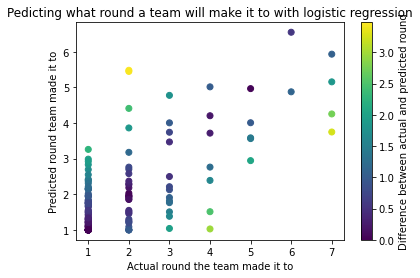

In [205]:
plt.scatter(comp_tourney['actual'], comp_tourney['pred'], c=comp_tourney['dif'])
plt.xlabel('Actual round the team made it to')
plt.ylabel("Predicted round team made it to")
plt.title("Pedicting what round a team will make it to with logistic regression")
plt.colorbar(label='Difference between actual and predicted round')

As you can see, the model is pretty good at predicting the teams that would exit in the first 2 rounds. After this, the model starts to guess incorrectly by an average of more than 1 round. It gets harder later to predict teams that will make it later because there are more games to play to get there and thus more variance. However, I am still quite pleased with this model's results.

# Now with conferences

I tried next remaking the same model, but using the conferences as a part of it. This required making new columns for each conference, and making the value 0 or a constant in each row depending on if that team were in the conference. I had to leave out the uncommon conferences and use 20 for my constant instead of 1, or the variance would be too low and I'd have a singular matrix.

In [206]:
uncommon = []
for conf in all_data['CONF'].unique():
    count = all_data['CONF'].str.count(conf).sum()
    if count < 10:
        uncommon.append(conf)
        

sep_data=all_data.replace({c:"UNCOMMON" for c in uncommon})
sep_data = sep_data[all_data['CONF'] != "UNCOMMON"]

sep_data = pd.concat((sep_data, pd.get_dummies(sep_data['CONF'])), axis=1)
for c in sep_data['CONF'].unique():
    sep_data[c] = sep_data[c].replace(1, 20)
    
feature_vectors = sep_data.drop(['TEAM', 'CONF', 'G', 'W', 'POSTSEASON', 'YEAR'], axis=1)
class_labels = sep_data['POSTSEASON']/7
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, random_state=1000)

logit_model = sm.Logit(train_labels, sm.add_constant(train_vectors))

result = logit_model.fit()
print(result.summary() )

         Current function value: 0.085667
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             POSTSEASON   No. Observations:                 2370
Model:                          Logit   Df Residuals:                     2318
Method:                           MLE   Df Model:                           51
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:                 -0.2274
Time:                        22:26:23   Log-Likelihood:                -203.03
converged:                      False   LL-Null:                       -165.42
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1725        nan        nan        nan         nan         nan
ADJOE          0.2830      0.086      3.275      0.001       0.11

/Users/ajb/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [207]:
output = result.predict(sm.add_constant(test_vectors))
comp = pd.concat([output*7, test_labels*7], axis=1)
comp.columns = ['pred', 'actual']
comp_tourney = comp[comp['actual'] > 0]
comp_tourney['pred'].values[comp_tourney['pred'] < 1] = 1 # tournament teams have to have at least a score of 1 because they made the tournament
comp_tourney['dif'] = abs(comp_tourney['pred'] - comp_tourney['actual'])
print("The mean difference in predicted round vs actual round that teams went to was ", comp_tourney['dif'].mean())
# sum(abs(test_labels - output)) / len(output)
# output_tourney = output[test_labels > 0]
first_round = comp_tourney[comp_tourney['actual'] == 1]
print("The mean difference in predicted round vs actual round for first round exit teams was", 
      first_round['dif'].mean())

second_round = comp_tourney[comp_tourney['actual'] == 2]
print("The mean difference in predicted round vs actual round for second round exit teams was", 
      second_round['dif'].mean())

third_round = comp_tourney[comp_tourney['actual'] == 3]
print("The mean difference in predicted round vs actual round for third round exit (sweet 16) teams was", 
      third_round['dif'].mean())

fourth_round = comp_tourney[comp_tourney['actual'] == 4]
print("The mean difference in predicted round vs actual round for fourth round exit (elite 8) teams was", 
      fourth_round['dif'].mean())

fifth_round = comp_tourney[comp_tourney['actual'] == 5]
print("The mean difference in predicted round vs actual round for fifth round exit (final 4) teams was", 
      fifth_round['dif'].mean())

sixth_round = comp_tourney[comp_tourney['actual'] == 6]
print("The mean difference in predicted round vs actual round for sixth round exit (runner up) teams was", 
      sixth_round['dif'].mean())

seventh_round = comp_tourney[comp_tourney['actual'] == 7]
print("The mean difference in predicted round vs actual round for championship teams was", 
      seventh_round['dif'].mean())

The mean difference in predicted round vs actual round that teams went to was  0.7477892018275512
The mean difference in predicted round vs actual round for first round exit teams was 0.5164193445373901
The mean difference in predicted round vs actual round for second round exit teams was 0.8338551559822805
The mean difference in predicted round vs actual round for third round exit (sweet 16) teams was 1.0571799538577493
The mean difference in predicted round vs actual round for fourth round exit (elite 8) teams was 1.2275918142554831
The mean difference in predicted round vs actual round for fifth round exit (final 4) teams was 1.2197731634548117
The mean difference in predicted round vs actual round for sixth round exit (runner up) teams was 1.1192242553654101
The mean difference in predicted round vs actual round for championship teams was 2.1814716483879995


/var/folders/xj/ls8gkxtd0bv2xyc2dbbnh81c0000gn/T/ipykernel_20323/2282581581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_tourney['dif'] = abs(comp_tourney['pred'] - comp_tourney['actual'])


In the end, using the teams conferences in my logistic regression model ended up making the model worse. The model without conferences missed the teams actual round by .60 on average, where as the model with conferences missed by .615 on average.